# Running runup models
In this notebook, we combine tidal, wave and slope data obtained in the previous notebooks to calculate wave runup on the beach. We use the py-wave-runup tool coded by:

> Chris Leaman, Tomas Beuzen, & Evan B. Goldstein. (2020). chrisleaman/py-wave-runup: v0.1.10 (v0.1.10). Zenodo. https://doi.org/10.5281/zenodo.3629949

In [34]:
# Import the libraries needed
from py_wave_runup import models
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.ticker as ticker
from scipy.stats import percentileofscore
import numpy as np
np.float = float #This is for compatibility of the py-wave-runup library

## Import data

First, we import wave, tidal and slope data calculated in the previous steps. Tp run this notebook, you should have at least have the results from the `1.Calculate_Tides.ipynb` and `3.Download_Wave_Data.ipynb`. If the results from the notebook `2.Extract_Shorelines_Tides.ipynb` are available, the slope values will be imported automatically.

In [35]:
from coastsat.CsatVe_select_folder import select_folder
# Call the function to select a folder and create additional folders for Waves
sitename_container = select_folder(create_additional_folders=True)
sitename = sitename_container["value"]
if sitename:
    print(f"The selected folder name is: {sitename}")
else:
    print("No folder was selected.")

No folder was selected.


In [36]:
sitename = sitename_container["value"]
# Define folders where data and images will be saved
outdata_path = os.path.join("Data", sitename, "Runup","data")
images_path = os.path.join("Data", sitename, "Runup","img")

## Import wave and tidal data
Now, we load the wave and tidal data from the csv files saved in the previous steps 

In [37]:
# Load wave data
waves = pd.read_csv(os.path.join('Data',sitename,'Waves','data','GLOBAL_REANALYSIS_WAV_001_032_waves_all.csv'), parse_dates=['time'])
waves['time'] = pd.to_datetime(waves['time'], format='%Y-%m-%d %H:%M:%S',utc=True)
#waves

#Load tide data
tides = pd.read_csv(os.path.join('Data',sitename,'water_levels',f'FES2022_tides_{sitename}.csv'), parse_dates=['dates'])
tides['dates'] = pd.to_datetime(tides['dates'], format='%Y-%m-%d %H:%M:%S.%f+00:00')
#tides

## Beach slope
For the beach slope (beta), two solutions are given. The first is to insert slope data from measured beach profiles or from other data. The second is to import them from the CoastSat.Slope workflow. 
Below, we provide a calculator in case you want to calculate the beach slope from two points surveyed in the field.

In [ ]:
import numpy as np
from scipy.stats import t

# Data
elevation_1 = 0.7166 # meters
elevation_2 = 1.6196 # meters
distance_1_2 = 26.179 # meters

vertical_precision = 0.01  # meters
horizontal_precision = 0.5  # meters

# Calculate slope
delta_elevation = elevation_2 - elevation_1
slope = delta_elevation / distance_1_2

# Propagation of uncertainty
slope_uncertainty = np.sqrt(
    (vertical_precision / distance_1_2) ** 2 +
    ((delta_elevation * horizontal_precision) / (distance_1_2 ** 2)) ** 2
)

# Confidence interval (assuming normal distribution, 95% confidence)
confidence_interval = t.ppf(0.975, df=1) * slope_uncertainty  # 95% confidence (two-tailed)

# 5-95% confidence interval
slope_lower_bound = slope - confidence_interval
slope_upper_bound = slope + confidence_interval

# Print results in Python format
print(f"Slope: {slope:.2f}")
print(f"Lower bound (5%): {slope_lower_bound:.2f}")
print(f"Upper bound (95%): {slope_upper_bound:.2f}")

In [ ]:
# Create the DataFrame with empty values or placeholders
slope = pd.DataFrame(columns=["Transect", "CI_Lower", "CI_Upper", "Slope"])

# Add the data
slope = pd.DataFrame({
    "Transect": [1],
    "CI_Lower": [0.02],
    "CI_Upper": [0.04],
    "Slope": [0.03]
})

# Display the DataFrame
print(slope)

# Save the DataFrame to a CSV file
slope.to_csv(os.path.join('Data',sitename,'slope_estimation','Transects_slope.csv'),index=False)

# If this cell is run, then save the "field measured" method in a text file
with open(os.path.join('Data',sitename,'slope_estimation','slope_method.txt'), 'w') as file:
    file.write("The beach slope was calculated from field-measured transects")

print("DataFrame saved to slope_data.csv")

Alternatively, import from the data saved by running the `2.Extract_Shorelines_Tides.ipynb` notebook

In [38]:
#Load slope data from CoastSat Workflow
slope = pd.read_csv(os.path.join('Data',sitename,'slope_estimation','Transects_slope.csv'))

# If this cell is run, then save the "CoastSat measured" method in a text file
with open(os.path.join('Data',sitename,'slope_estimation','slope_method.txt'), 'w') as file:
    file.write("The beach slope was calculated from transects derived from CoastSat.Slope")


slope

,Transect,CI_Lower,CI_Upper,Slope
0,1,0.0785,0.0885,0.081000
1,2,0.0760,0.0835,0.081000
2,3,0.0735,0.0810,0.076000
3,4,0.0710,0.0760,0.075999
4,5,0.0760,0.0835,0.081000


### Modern wave runup

First, we calculate runup for all waves with direction perpendicular to the coast. To each calculated runup, we add the corresponding tidal level. 

For which concerns slope, we sample random slopes from the frequency distributions of the slopes extracted for each transect from CoastSat.slope.

### Coupling wave and tidal data
First, we couple the waves and tide data by their timestamps.

In [39]:
# Sort both dataframes by the 'date' columns
waves.sort_values('time', inplace=True)
tides.sort_values('dates', inplace=True)
# Merge the dataframes based on the closest date and time
df = pd.merge_asof(waves, tides, left_on='time', right_on='dates', direction='nearest')
# Calculate the time difference in minutes and format the column
df['time_diff'] = ((df['time'] - df['dates']).dt.total_seconds() / 60).round(2)
waves_tides=df.copy()

#waves_tides

### Slope calculation
We then calculate a probabilistic distribution (`random.triangular` sampling) of slope values from the 5-95% confidence intervals extracted from CoastSat.slope, and plot the results. Note that in this step, only slopes from 0.01 to 0.4 are retained in the analysis. Higher or lower slopes are generally unrealistic.

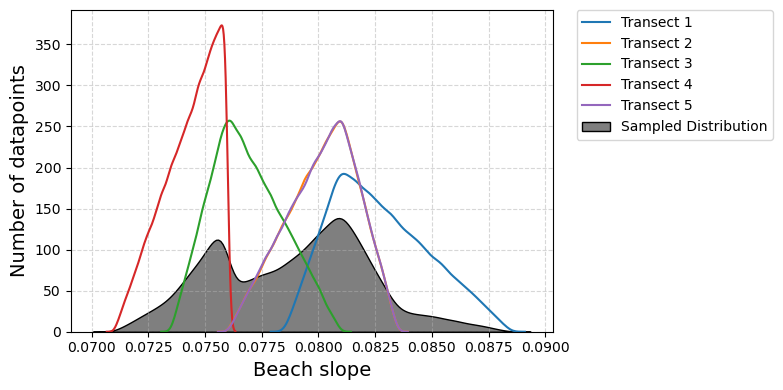

In [40]:
from coastsat.CsatVe_beach_slope import generate_random_samples,beach_slope_plot
# Seed for repeatability
random_seed = 42
np.random.seed(random_seed)
# Generate the random sample dataframe
random_samples_df = generate_random_samples(slope, len(waves_tides), seed=random_seed)
# Call the updated plotting function
beach_slope_plot(slope, random_samples_df,images_path)

### Calculate runup
We use `py-wave-runup` to calculate runup with different models. Note that Beuzen et al. was not implemented here because of an incompatibility betweeen the environment of CoastSat.Venice and that of the code of Beuzen et al.
For the calculations by Power et al. (2018), the user needs to insert grain size. Default value is 1.5 mm (very coarse sands)

In [41]:
# Inputs
VHM0 = waves_tides['VHM0'].tolist()
VTPK = waves_tides['VTPK'].tolist()
tide = waves_tides['tide'].tolist()

grainsize=0.008/1000 # grainsize in m, required for Power et al.
r=grainsize*2.5

runup = {'Stockdon et al. (2006)': (models.Stockdon2006(Hs=VHM0, Tp=VTPK, beta=random_samples_df.Sampled_Value)).R2+tide,
        'Vousdoukas et al. (2012)': (models.Vousdoukas2012(Hs=VHM0, Tp=VTPK, beta=random_samples_df.Sampled_Value)).R2+tide,
        'Holman (1986)': (models.Holman1986(Hs=VHM0, Tp=VTPK, beta=random_samples_df.Sampled_Value)).R2+tide,
        'Nielsen (2009)': (models.Nielsen2009(Hs=VHM0, Tp=VTPK, beta=random_samples_df.Sampled_Value)).R2+tide,
        'Ruggiero et al. (2001)': (models.Ruggiero2001(Hs=VHM0, Tp=VTPK, beta=random_samples_df.Sampled_Value)).R2+tide,
        'Atkinson et al. (2017)': (models.Atkinson2017(Hs=VHM0, Tp=VTPK, beta=random_samples_df.Sampled_Value)).R2+tide,
        'Senechal et al. (2011)': (models.Senechal2011(Hs=VHM0, Tp=VTPK, beta=random_samples_df.Sampled_Value)).R2+tide,
        'Passarella et al. (2018)': (models.Passarella2018(Hs=VHM0, Tp=VTPK, beta=random_samples_df.Sampled_Value)).swash+tide,
        'Power et al. (2018)': (models.Power2018(Hs=VHM0, Tp=VTPK, beta=random_samples_df.Sampled_Value,r=r)).R2+tide}

# Create dataframe of runup values
R2 = pd.DataFrame(runup)
R2 = pd.merge(R2, waves_tides, left_index=True, right_index=True)
columns = ['Stockdon et al. (2006)',
           'Vousdoukas et al. (2012)',
           'Holman (1986)',
           'Nielsen (2009)',
           'Ruggiero et al. (2001)',
           'Atkinson et al. (2017)',
           'Senechal et al. (2011)',
           'Passarella et al. (2018)',
          'Power et al. (2018)']

## Filter and plot runup values
We then filter the runup values calculated in the step above using these criteria:
1. angle: we select only the runup for shore-perpendicular waves
2. We retain only runup values above sea-level (those contributing to build morphological elements in the foreshore)

In [46]:
# 1. Change wave angles to keep only shore-perpendicular waves
min_wave_angle = 30
max_wave_angle = 150
R2_filter = R2[(R2['VMDR'] >= min_wave_angle) & (R2['VMDR'] <= max_wave_angle)]

# 2. Filter out rows where any of the specified columns have negative values
R2_filter = R2_filter[(R2_filter[columns] > 0).all(axis=1)]

We now plot the runup values

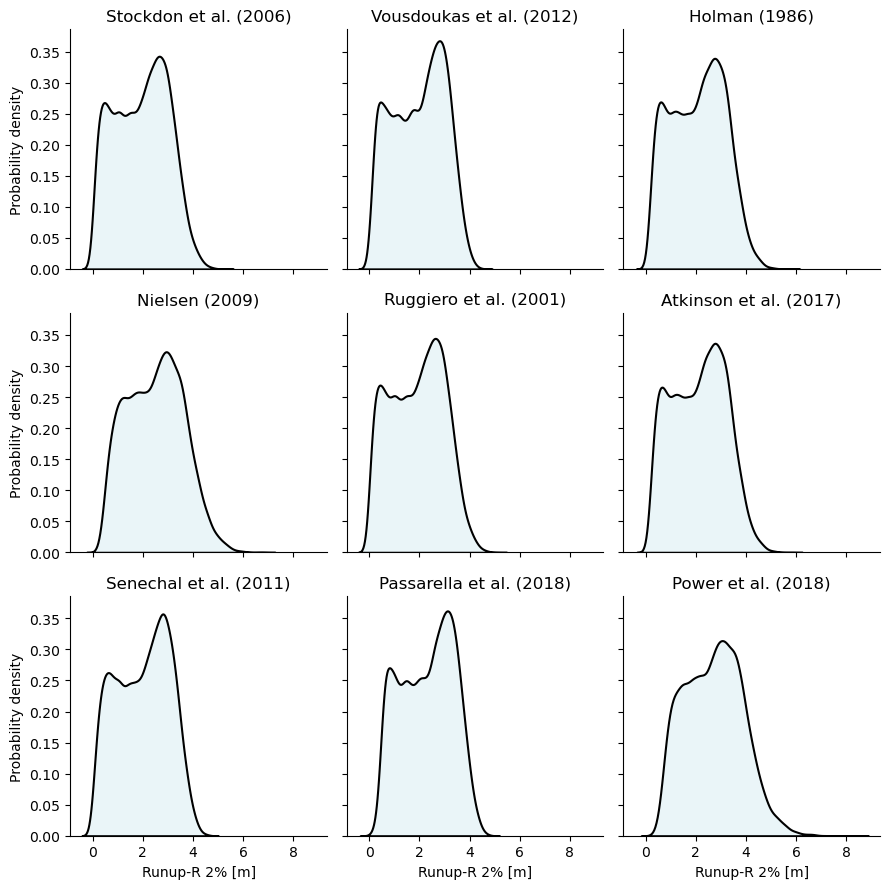

In [47]:
# Create FacetGrid object
grid = sns.FacetGrid(R2_filter.melt(value_vars=columns), col="variable", col_wrap=3, height=3)

# Plot KDE distributions with filled areas
grid.map(
    sns.kdeplot, 
    "value", 
    fill=True, 
    color="lightblue",  # Fill color
    edgecolor="k",  # KDE line color
    linewidth=1.5  # Line thickness
)

# Update titles and labels
for ax, col, title in zip(grid.axes.flat, columns, columns):
    ax.set_title(title)
    ax.set_xlabel('Runup-R 2% [m]')
    ax.set_ylabel('Probability density')

# Adjust layout and display the plot
plt.tight_layout()
plt.savefig(os.path.join(images_path, 'runup_modern_all.pdf'), dpi=300)
plt.show()

### Validate wave runup (optional)
To validate the runup models, we extract the model results for the time of survey, when we measured the elevation of the swash zone and the beach cusps, which are created by wave runup.

**If no data is available from the modern shoreline, this step can be skipped**

In [48]:
# Elevation of the instantaneous swash zone 
El1 = 0.55
El1_1s=0.30

# Time of survey
survey_date_time_str = '2019-11-02 15:55:41+00:00'

In [49]:
# Convert string to datetime object
survey_date_time = datetime.strptime(survey_date_time_str, '%Y-%m-%d %H:%M:%S%z')
# Remove timezone information to make it timezone-naive
survey_date_time = survey_date_time.replace(tzinfo=None)

# Assuming R2 is your DataFrame and it has a 'time' column with datetime objects
# Convert 'time' column to datetime if it's not already
R2['time'] = pd.to_datetime(R2['time']).dt.tz_localize(None)

# Find the row with the closest date and time
closest_datapoint = R2.loc[(R2['time'] - survey_date_time).abs().idxmin()]

# Save data to CSV file
closest_datapoint.to_csv(os.path.join(outdata_path, 'runup_survey_time.csv'), index=True)

closest_datapoint

Stockdon et al. (2006)                       0.296211
Vousdoukas et al. (2012)                     0.388359
Holman (1986)                                0.424191
Nielsen (2009)                               0.792597
Ruggiero et al. (2001)                       0.275947
Atkinson et al. (2017)                       0.449178
Senechal et al. (2011)                       0.483708
Passarella et al. (2018)                     0.732207
Power et al. (2018)                          1.027874
time                              2019-11-02 15:00:00
VHM0                                             1.39
VTPK                                             7.94
VMDR                                            42.08
dates                       2019-11-02 15:00:00+00:00
tide                                           -0.597
time_diff                                         0.0
Name: 116405, dtype: object

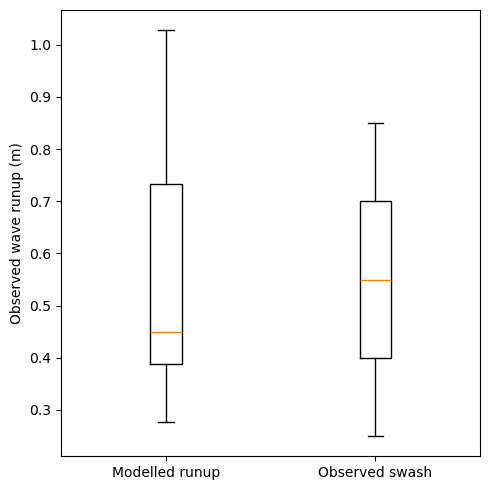

In [50]:
columns = ['Stockdon et al. (2006)',
           'Vousdoukas et al. (2012)',
           'Holman (1986)',
           'Nielsen (2009)',
           'Ruggiero et al. (2001)',
           'Atkinson et al. (2017)',
           'Senechal et al. (2011)',
           'Passarella et al. (2018)',
          'Power et al. (2018)']
R2_values = closest_datapoint[columns].tolist()
# Combine the values with the swash zone data and 1-sigma range
combined_data = [R2_values, [El1 - El1_1s, El1 + El1_1s]]
# Plotting the box plot
plt.figure(figsize=(5, 5))
plt.boxplot(combined_data, tick_labels=['Modelled runup', 'Observed swash'], vert=True)
plt.ylabel('Observed wave runup (m)')
plt.tight_layout()
plt.savefig(os.path.join(images_path,'benchmark_runup.pdf'),dpi=300)
plt.show()

The data is then saved

In [51]:
overall_data = R2_filter.melt(value_vars=columns)
overall_data.to_csv(os.path.join(outdata_path, 'runup_modern_total.csv'), index=True)

## Wave runup beyond the instrumental record

To calculate wave runup beyond the instrumental record, we need to assume that each wave condition in the instrumental record might have happened during different tidal stages, and that wave directions might have varied. Therefore we resample the waves and tides data to produce one million possible combinations.

First, we sample the slope. We plot the sampled slope and the original one to make sure they are equivalent.

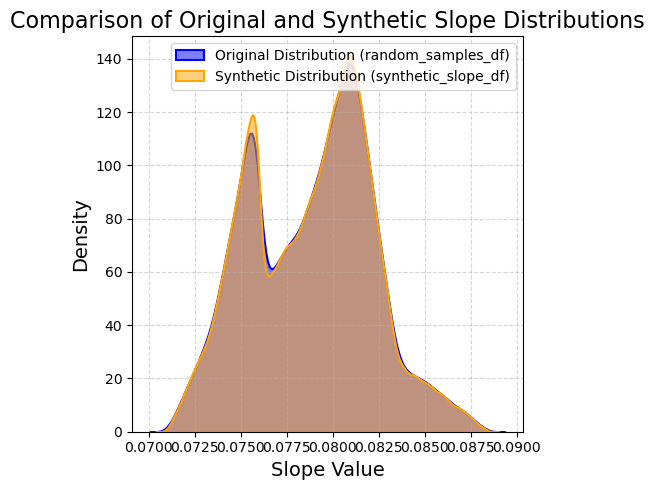

In [52]:
# NUmber of wave/tide conditions in the dataset
n=1000000

# Assuming random_samples_df is already defined
random_seed = 42
np.random.seed(random_seed)

# Generate synthetic slopes
synthetic_slopes = np.random.choice(random_samples_df['Sampled_Value'].values, size=1000000, replace=True)
synthetic_slope_df = pd.DataFrame({'Slope': synthetic_slopes})

# Plot the distribution of random_samples_df and synthetic_slope_df
plt.figure(figsize=(5, 5))

# KDE plot for random_samples_df
sns.kdeplot(
    random_samples_df['Sampled_Value'],
    fill=True,
    color="blue",
    alpha=0.5,
    linewidth=1.5,
    label="Original Distribution (random_samples_df)"
)

# KDE plot for synthetic_slope_df
sns.kdeplot(
    synthetic_slope_df['Slope'],
    fill=True,
    color="orange",
    alpha=0.5,
    linewidth=1.5,
    label="Synthetic Distribution (synthetic_slope_df)"
)

# Add title and labels
plt.title("Comparison of Original and Synthetic Slope Distributions", fontsize=16)
plt.xlabel("Slope Value", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.legend(loc='upper right')
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.tight_layout()

# Display the plot
plt.show()

Then, we produce a synthetic datasets of waves and tides. We only select tides above sea level, and we filter only the waves incident perpendicular to the shore, as defined for the modern dataset. 

In [53]:
# filter waves and tides datasets
waves_filter= waves[(waves['VMDR'] >= min_wave_angle) & (waves['VMDR'] <= max_wave_angle)]
waves_filter.reset_index(drop=True, inplace=True)

tides_filter=tides[(tides['tide'] > 0)]
tides_filter.reset_index(drop=True, inplace=True)

# Create a synthetic wave/tide dataset
sampled_tides = tides_filter.sample(n=n, replace=True)
sampled_waves = waves_filter.sample(n=n, replace=True)

# Sample pairs of VHM0 and VTPK from waves_filter
sampled_waves = waves_filter[['VHM0', 'VTPK']].sample(n=n, replace=True, random_state=1).reset_index(drop=True)
# Sample tide values from tides_filter
sampled_tide = tides_filter['tide'].sample(n=n, replace=True, random_state=1).reset_index(drop=True)
# Combine the sampled data into a new dataframe
synth_ensamble = pd.concat([sampled_waves, sampled_tide], axis=1)

We then simulate the runup, using the same settings of grain size for Power et al (2018) that was set above.

In [54]:
# Inputs
VHM0 = synth_ensamble['VHM0'].tolist()
VTPK = synth_ensamble['VTPK'].tolist()
tide = synth_ensamble['tide'].tolist()

runup = {'Stockdon et al. (2006)': (models.Stockdon2006(Hs=VHM0, Tp=VTPK, beta=synthetic_slope_df.Slope)).R2+tide,
        'Vousdoukas et al. (2012)': (models.Vousdoukas2012(Hs=VHM0, Tp=VTPK, beta=synthetic_slope_df.Slope)).R2+tide,
        'Holman (1986)': (models.Holman1986(Hs=VHM0, Tp=VTPK, beta=synthetic_slope_df.Slope)).R2+tide,
        'Nielsen (2009)': (models.Nielsen2009(Hs=VHM0, Tp=VTPK, beta=synthetic_slope_df.Slope)).R2+tide,
        'Ruggiero et al. (2001)': (models.Ruggiero2001(Hs=VHM0, Tp=VTPK, beta=synthetic_slope_df.Slope)).R2+tide,
        'Atkinson et al. (2017)': (models.Atkinson2017(Hs=VHM0, Tp=VTPK, beta=synthetic_slope_df.Slope)).R2+tide,
        'Senechal et al. (2011)': (models.Senechal2011(Hs=VHM0, Tp=VTPK, beta=synthetic_slope_df.Slope)).R2+tide,
        'Passarella et al. (2018)': (models.Passarella2018(Hs=VHM0, Tp=VTPK, beta=synthetic_slope_df.Slope)).swash+tide,
        'Power et al. (2018)': (models.Power2018(Hs=VHM0, Tp=VTPK, beta=synthetic_slope_df.Slope,r=r)).R2+tide
        }

# Create dataframe of runup values
R2_synth = pd.DataFrame(runup)
columns = ['Stockdon et al. (2006)',
           'Vousdoukas et al. (2012)',
           'Holman (1986)',
           'Nielsen (2009)',
           'Ruggiero et al. (2001)',
           'Atkinson et al. (2017)',
           'Senechal et al. (2011)',
           'Passarella et al. (2018)',
          'Power et al. (2018)']

# Filter out rows where any of the specified columns have negative values
R2_synth_filter = R2_synth[(R2_synth[columns] > 0).all(axis=1)]

# Save the rejected rows (where any value is negative)
R2_synth_rejected = R2_synth[(R2_synth[columns] <= 0).any(axis=1)]

R2_synth.reset_index(drop=True, inplace=True)

## Plot modern and synthetic runup
The modern and sythetic runup are plotted on a two-panel plot.

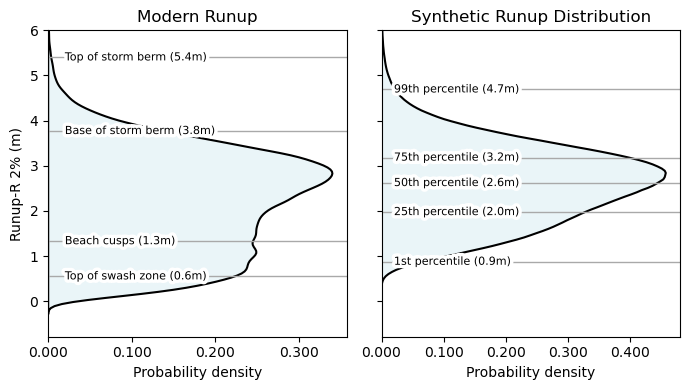

In [69]:
import matplotlib.patheffects as path_effects
from matplotlib.patheffects import withStroke

# Create a two-panel figure
fig, axes = plt.subplots(1, 2, figsize=(7, 4),sharey=True)  # Two panels side by side

# First Panel: Original KDE Plot
overall_data = R2_filter.melt(value_vars=columns)

# Define the elevation of morphological elements to plot
Top_swash = 0.55
Beach_cusps = 1.33
Base_berm = 3.77
Top_berm = 5.4

sns.kdeplot(
    data=overall_data,
    y='value',
    fill=True,
    color="lightblue",
    linewidth=1.5,
    ax=axes[0],
    edgecolor='k'
)

axes[0].set_title('Modern Runup')
axes[0].set_xlabel('Probability density')
axes[0].set_ylabel('Runup-R 2% (m)')

key_points = [
    (Top_swash, f'Top of swash zone ({Top_swash:.1f}m)'),
    (Beach_cusps, f'Beach cusps ({Beach_cusps:.1f}m)'),
    (Base_berm, f'Base of storm berm ({Base_berm:.1f}m)'),
    (Top_berm, f'Top of storm berm ({Top_berm:.1f}m)'),
]

for y_value, label in key_points:
    axes[0].axhline(y_value, color='darkgray', linestyle='-', linewidth=1)
    text = axes[0].text(
        0.02, y_value, label, 
        color='k', fontsize=8, 
        verticalalignment='center', 
        horizontalalignment='left'
    )
    text.set_path_effects([
        path_effects.Stroke(linewidth=5, foreground="white"),
        path_effects.Normal()
    ])

axes[0].xaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))

# Second Panel: Overall Synthetic Distribution
overall_synth = R2_synth_filter.melt(value_vars=columns)
percentiles = overall_synth['value'].quantile([0.01,0.25,0.5,0.75, 0.99])

sns.kdeplot(
    data=overall_synth,
    y='value',
    fill=True,
    color="lightblue",
    linewidth=1.5,
    ax=axes[1],
    edgecolor='k'
)

axes[1].set_title('Synthetic Runup Distribution')
axes[1].set_xlabel('Probability density')

key_points = [
    (percentiles.iloc[0], f'1st percentile ({percentiles.iloc[0]:.1f}m)'),
    (percentiles.iloc[1], f'25th percentile ({percentiles.iloc[1]:.1f}m)'),
    (percentiles.iloc[2], f'50th percentile ({percentiles.iloc[2]:.1f}m)'),
    (percentiles.iloc[3], f'75th percentile ({percentiles.iloc[3]:.1f}m)'),
    (percentiles.iloc[4], f'99th percentile ({percentiles.iloc[4]:.1f}m)')
]

for y_value, label in key_points:
    axes[1].axhline(y_value, color='darkgray', linestyle='-', linewidth=1)
    text = axes[1].text(
        0.02, y_value, label, 
        color='k', fontsize=8, 
        verticalalignment='center', 
        horizontalalignment='left'
    )
    text.set_path_effects([
        path_effects.Stroke(linewidth=5, foreground="white"),
        path_effects.Normal()
    ])

axes[1].xaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))

# Adjust as needed
axes[0].set_ylim(None, 6)
axes[1].set_ylim(None, 6)

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig(os.path.join(images_path, 'two_panel_runup.pdf'), dpi=300)
plt.show()

In [67]:
overall_synth.to_csv(os.path.join(outdata_path, 'runup_synth_total.csv'), index=True)
percentiles.to_csv((os.path.join(outdata_path, 'percentiles.csv')), header=True)

## Acknowledgments
This code uses the FES2022 Tide product, funded by CNES, produced by LEGOS, NOVELTIS and CLS and made freely available by AVISO. CNES, 2024. FES2022 (Finite Element Solution) Ocean Tide (Version 2022) [Data set]. CNES. https://doi.org/10.24400/527896/A01-2024.004

- Carrere et al., OSTST 2022: A new barotropic tide model for global ocean: FES2022,
https://doi.org/10.24400/527896/a03-2022.3287

- Florent H. Lyard, Loren Carrere, Ergane Fouchet, Mathilde Cancet, David Greenberg, Gérald Dibarboure and Nicolas Picot: “FES2022 a step towards a SWOT-compliant tidal correction”, to be submitted to Ocean Sciences.

FES22 data are used herein under the terms of the [license agreement](https://www.aviso.altimetry.fr/fileadmin/documents/data/License_Aviso.pdf)

Wave data in this code are generated using the E.U. Copernicus Marine Service Information. Data is available at this [link]( https://doi.org/10.48670/moi-00022). 

CoastSat.Venice was coded the framework of the WARMCOASTS project, led by A. Rovere at Ca' Foscari University of Venice. This software is part of a project that has received funding from the European Research Council (ERC) under the European Union’s Horizon 2020 research and innovation programme (Grant agreement No. ERC-StG-802414)
